In [1]:
!pip install openai --quiet
!pip install tenacity --quiet
!pip install tqdm --quiet
!pip install numpy --quiet
!pip install typing --quiet
!pip install tiktoken --quiet
!pip install concurrent --quiet

ERROR: Could not find a version that satisfies the requirement concurrent (from versions: none)
ERROR: No matching distribution found for concurrent


In [13]:
!wget -q https://raw.githubusercontent.com/anshupandey/Generative-AI-for-Professionals/main/datasets/sample_clothes.zip

In [14]:
!unzip -q sample_clothes.zip

In [ ]:
import pandas as pd
import time
import json, os, re
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from azure.keyvault.secrets import SecretClient
from azure.identity import DefaultAzureCredential
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from langfuse.callback import CallbackHandler
from langchain_chroma import Chroma
from typing import TypedDict, List, Dict
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.schema.runnable import RunnableMap, RunnableLambda
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display
from langchain.schema.messages import HumanMessage, SystemMessage, ToolMessage

In [3]:
import pandas as pd
import numpy as np
import json
import ast
import tiktoken
import concurrent
from openai import OpenAI
from tqdm import tqdm
from tenacity import retry, wait_random_exponential, stop_after_attempt
from IPython.display import Image, display, HTML
from typing import List
import os


KVUri = "https://dipanjans-kv.vault.azure.net"
credential = DefaultAzureCredential()
client = SecretClient(vault_url=KVUri, credential=credential)

oai_endpoint= client.get_secret("azure-openai-endpoint")
oai_key=      client.get_secret("azure-openai-key")
oai_endpoint_embed= client.get_secret("azure-openai-endpoint-embed")
oai_key_embed=      client.get_secret("azure-openai-key-embed")
oai_endpoint_embed_3= 'https://dipanjan-oai.openai.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2023-05-15'
oai_key_embed_3     = 'E2EyDw7HealrkGoWMO3sbu9nCZ22rN8oWo3MTVzePBnPczmfihbYJQQJ99BEACYeBjFXJ3w3AAABACOGr5SL'

llm = AzureChatOpenAI(api_version="2024-12-01-preview",
                        model='gpt-40-mini' , 
                        azure_endpoint= oai_endpoint.value,
                        api_key = oai_key.value)

embeds = AzureOpenAIEmbeddings(azure_deployment="text-embedding-3-large",
                        model = 'text-embedding-3-large',
                        azure_endpoint= oai_endpoint_embed_3,
                        api_key = oai_key_embed_3)

EMBEDDING_COST_PER_1K_TOKENS = 0.02


In [4]:
styles_filepath = "sample_clothes/sample_styles.csv"
styles_df = pd.read_csv(styles_filepath, on_bad_lines='skip')
print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt  
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts  
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt  
3  2012.0  Ethnic                  Fabindia Men Blue Kurta  
4  2012.0  Ethnic        Shree Women Multi Colored Patiala  
Opened dataset successfully. Dataset has 1000 items of clothing.


In [ ]:
import concurrent.futures
from typing import List
import tiktoken
from tenacity import retry, wait_random_exponential, stop_after_attempt
from tqdm import tqdm

# Constants
EMBEDDING_COST_PER_1K_TOKENS = 0.0001


# Retry wrapper for embedding calls
@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(5))
def get_embeddings(input_texts: List[str]):
    return embeds.embed_documents(input_texts)

# Utility to split input into batches
def batchify(iterable, n=1):
    for i in range(0, len(iterable), n):
        yield iterable[i : i + n]

# Main embedding function for corpus
def embed_corpus(
    corpus: List[str],
    batch_size=64,
    num_workers=8,
    max_context_len=8191,
):
    encoding = tiktoken.get_encoding("cl100k_base")
    # Truncate each string based on token length
    trimmed_corpus = []
    for doc in corpus:
        tokens = encoding.encode(doc)[:max_context_len]
        trimmed_text = encoding.decode(tokens)
        trimmed_corpus.append(trimmed_text)

    # cost estimation
    # num_tokens = sum(len(encoding.encode(doc)) for doc in trimmed_corpus)
    # cost_to_embed = num_tokens / 1000 * EMBEDDING_COST_PER_1K_TOKENS
    # print(f"num_articles={len(trimmed_corpus)}, num_tokens={num_tokens}, est_embedding_cost={cost_to_embed:.4f} USD")

    # Parallel embedding
    embeddings = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(get_embeddings, batch) for batch in batchify(trimmed_corpus, batch_size)]
        
        print("len_trimmed_corpus",len(trimmed_corpus))
        with tqdm(total=len(trimmed_corpus)) as pbar:
            for future in concurrent.futures.as_completed(futures):
                try:
                    batch_embeddings = future.result()
                    embeddings.extend(batch_embeddings)
                    pbar.update(len(batch_embeddings))
                except Exception as e:
                    print(f"Batch failed: {e}")

    return embeddings

# Embedding a column in a DataFrame
def generate_embeddings(df, column_name: str):
    corpus = df[column_name].astype(str).tolist()
    embeddings = embed_corpus(corpus)
    df["embeddings"] = embeddings
    print("Embeddings created successfully.")
    return df

# len((embed_corpus(['What is your name']))[0])

In [12]:
generate_embeddings(styles_df, 'productDisplayName')
print("Writing embeddings to file ...")
styles_df.to_csv('sample_clothes/sample_styles_with_embeddings.csv', index=False)
print("Embeddings successfully stored in sample_styles_with_embeddings.csv")

num_articles=1000, num_tokens=8280, est_embedding_cost=0.0008 USD
len_trimmed_corpus 1000


100%|██████████| 1000/1000 [01:34<00:00, 10.61it/s]


Embeddings created successfully.
Writing embeddings to file ...
Embeddings successfully stored in sample_styles_with_embeddings.csv


In [14]:
styles_df = pd.read_csv('sample_clothes/sample_styles_with_embeddings.csv', on_bad_lines='skip')
styles_df.columns
# Convert the 'embeddings' column from string representations of lists to actual lists of floats
styles_df['embeddings'] = styles_df['embeddings'].apply(lambda x: ast.literal_eval(x))

print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing along with their embeddings.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  \
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt   
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts   
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt   
3  2012.0  Ethnic                  Fabindia Men Blue Kurta   
4  2012.0  Ethnic        Shree Women Multi Colored Patiala   

                                          embeddings  
0  [0.0006296030478551984, 0.05689839646220207, -...  
1  [-0.003143639536574483, 0.036229733377695084, ...  

In [15]:
def cosine_similarity_manual(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    vec1 = np.array(vec1, dtype=float)
    vec2 = np.array(vec2, dtype=float)


    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)


def find_similar_items(input_embedding, embeddings, threshold=0.5, top_k=2):
    """Find the most similar items based on cosine similarity."""

    # Calculate cosine similarity between the input embedding and all other embeddings
    similarities = [(index, cosine_similarity_manual(input_embedding, vec)) for index, vec in enumerate(embeddings)]

    # Filter out any similarities below the threshold
    filtered_similarities = [(index, sim) for index, sim in similarities if sim >= threshold]

    # Sort the filtered similarities by similarity score
    sorted_indices = sorted(filtered_similarities, key=lambda x: x[1], reverse=True)[:top_k]

    # Return the top-k most similar items
    return sorted_indices

In [17]:
def find_matching_items_with_rag(df_items, item_descs):
   """Take the input item descriptions and find the most similar items based on cosine similarity for each description."""

   # Select the embeddings from the DataFrame.
   embeddings = df_items['embeddings'].tolist()


   similar_items = []
   for desc in item_descs:

      # Generate the embedding for the input item
      input_embedding = get_embeddings([desc])

      # Find the most similar items based on cosine similarity
      similar_indices = find_similar_items(input_embedding, embeddings, threshold=0.6)
      similar_items += [df_items.iloc[i] for i in similar_indices]

   return similar_items

In [ ]:
def analyze_image(image_base64, subcategories):
    PromptTemplate.from_template("""Given an image of an item of clothing, analyze the item and generate a JSON output with the following fields: "items", "category", and "gender".
                        Use your understanding of fashion trends, styles, and gender preferences to provide accurate and relevant suggestions for how to complete the outfit.
                        The items field should be a list of items that would go well with the item in the picture. Each item should represent a title of an item of clothing that contains the style, color, and gender of the item.
                        The category needs to be chosen between the types in this list: {subcategories}.
                        You have to choose between the genders in this list: [Men, Women, Boys, Girls, Unisex]
                        Do not include the description of the item in the picture. Do not include the ```json ``` tag in the output.

                        Example Input: An image representing a black leather jacket.

                        Example Output: {"items": ["Fitted White Women's T-shirt", "White Canvas Sneakers", "Women's Black Skinny Jeans"], "category": "Jackets", "gender": "Women"}
                        """)
    
    generate_prompt.invoke({"subcategories": subcategories, "retrieved_snippets":retrieved_snippets})
        
    
    # Extract relevant features from the response
    features = response.choices[0].message.content
    return features

In [34]:
# Create the prompt string
def analyze_image(image_base64, subcategories):
    prompt_text = f"""
    Given an image of an item of clothing, analyze the item and generate a JSON output with the following fields: "items", "category", and "gender".
    Use your understanding of fashion trends, styles, and gender preferences to provide accurate and relevant suggestions for how to complete the outfit.
    The items field should be a list of items that would go well with the item in the picture. Each item should represent a title of an item of clothing that contains the style, color, and gender of the item.
    The category needs to be chosen between the types in this list: {subcategories}.
    You have to choose between the genders in this list: [Men, Women, Boys, Girls, Unisex]
    Do not include the description of the item in the picture. Do not include the ```json``` tag in the output.

    Example Input: An image representing a black leather jacket.

    Example Output: {{"items": ["Fitted White Women's T-shirt", "White Canvas Sneakers", "Women's Black Skinny Jeans"], "category": "Jackets", "gender": "Women"}}
    """

    # Construct the message with multimodal content
    message = HumanMessage(
        content=[
            {"type": "text", "text": prompt_text},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{image_base64}"
                },
            },
        ]
    )

    # Call the model
    response = llm.invoke([message])
    print('resp_content', response.content)
    return response.content


In [35]:
import base64

def encode_image_to_base64(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

In [36]:
# Set the path to the images and select a test image
image_path = "sample_clothes/sample_images/"
test_images = ["2133.jpg", "7143.jpg", "4226.jpg"]

# Encode the test image to base64
reference_image = image_path + test_images[0]
encoded_image = encode_image_to_base64(reference_image)

resp_content {"items": ["Beige Chinos for Men", "Brown Casual Leather Shoes", "Navy Blue Denim Jacket for Men"], "category": "Shirts", "gender": "Men"}


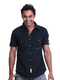

{'items': ['Beige Chinos for Men', 'Brown Casual Leather Shoes', 'Navy Blue Denim Jacket for Men'], 'category': 'Shirts', 'gender': 'Men'}


In [37]:
# Select the unique subcategories from the DataFrame
unique_subcategories = styles_df['articleType'].unique()

# Analyze the image and return the results
analysis = analyze_image(encoded_image, unique_subcategories)
image_analysis = json.loads(analysis)

# Display the image and the analysis results
display(Image(filename=reference_image))
print(image_analysis)

513 Remaining Items
[id    22366
Name: 68, dtype: object, id    11950
Name: 356, dtype: object, id    20156
Name: 260, dtype: object, id    22139
Name: 534, dtype: object]
['Beige Chinos for Men', 'Brown Casual Leather Shoes', 'Navy Blue Denim Jacket for Men']


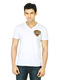

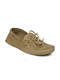

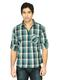

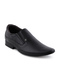

In [41]:
# Extract the relevant features from the analysis
item_descs = image_analysis['items']
item_category = image_analysis['category']
item_gender = image_analysis['gender']


# Filter data such that we only look through the items of the same gender (or unisex) and different category
filtered_items = styles_df.loc[styles_df['gender'].isin([item_gender, 'Unisex'])]
filtered_items = filtered_items[filtered_items['articleType'] != item_category]
print(str(len(filtered_items)) + " Remaining Items")

# Find the most similar items based on the input item descriptions
matching_items = find_matching_items_with_rag(filtered_items, item_descs)
print(matching_items)

# Display the matching items (this will display 2 items for each description in the image analysis)
html = ""
paths = []
for i, item in enumerate(matching_items):
    item_id = item['id']

    # Path to the image file
    image_path = f'./sample_clothes/sample_images/{item_id}.jpg'
    paths.append(image_path)
    html += f'<img src="{image_path}" style="display:inline;margin:1px"/>'

# Print the matching item description as a reminder of what we are looking for
print(item_descs)
# Display the image
for pth in paths:
  display(Image(filename=pth))

In [43]:
def check_match(reference_image_base64: str, suggested_image_base64: str) -> str:
    prompt_text = """
    You will be given two images of two different items of clothing.
    Your goal is to decide if the items in the images would work in an outfit together.
    The first image is the reference item (the item that the user is trying to match with another item).
    You need to decide if the second item would work well with the reference item.
    Your response must be a JSON output with the following fields: "answer", "reason".
    The "answer" field must be either "yes" or "no", depending on whether you think the items would work well together.
    The "reason" field must be a short explanation of your reasoning for your decision. Do not include the descriptions of the 2 images.
    Do not include the ```json``` tag in the output.
    """

    message = HumanMessage(
        content=[
            {"type": "text", "text": prompt_text},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{reference_image_base64}"}},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{suggested_image_base64}"}}
        ]
    )

    # Invoke the model
    response = llm.invoke([message])
    return response.content



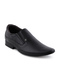

The items match!
Both items are in black, which creates a cohesive look. The shirt's casual style can pair well with the more formal shoe, balancing the outfit.


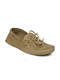

The items match!
The black shirt is versatile and matches well with the neutral color of the shoes, creating an overall balanced look.


In [44]:
# Select the unique paths for the generated images
paths = list(set(paths))

for path in paths:
    # Encode the test image to base64
    suggested_image = encode_image_to_base64(path)

    # Check if the items match
    match = json.loads(check_match(encoded_image, suggested_image))

    # Display the image and the analysis results
    if match["answer"] == 'yes':
        display(Image(filename=path))
        print("The items match!")
        print(match["reason"])